# Advanced Reiss Lab Data Analysis Pipeline
**Subject Analysis: Vowel, Consonant, and CRM Experiments**

This notebook integrates standard accuracy metrics with advanced phonetic feature analysis, statistical testing, temporal tracking, and interactive data exploration.

## 1. Setup and Dependencies
Ensure you have the required statistical and plotting libraries installed.

In [1]:
!pip install pandas numpy seaborn matplotlib scipy statsmodels plotly ipywidgets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
import os
import re

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## 2. Data Loading & Preprocessing
Standard ingestion of Vowel, Consonant, and CRM logs.

In [3]:
# --- HELPER FUNCTIONS ---

def parse_crm_header(filepath):
    try:
        with open(filepath, 'r') as f:
            header = f.readline()
        match = re.search(r'Talker (\d+), Maskers (\d+) and (\d+)', header)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
    except: pass
    return None, None, None

def get_gender(talker_id):
    return 'M' if talker_id <= 3 else 'F'

def get_masker_type(talker, masker1, masker2):
    if talker is None: return 'unknown'
    t_gen, m1_gen, m2_gen = get_gender(talker), get_gender(masker1), get_gender(masker2)
    if t_gen == m1_gen == m2_gen: return 'same'
    if m1_gen == m2_gen and m1_gen != t_gen: return 'different'
    return 'mixed'

def calculate_srt(df_run):
    # Simple reversal logic matching Matlab protocols
    snr = df_run['snr'].values
    correct = ((df_run['target_color'] == df_run['response_color']) & 
               (df_run['target_number'] == df_run['response_number'])).values
    reversals = []
    prev = correct[0]
    for i in range(1, len(correct)):
        if correct[i] != prev:
            reversals.append(snr[i])
        prev = correct[i]
    
    if len(reversals) >= 5:
        # Use reversals 5 through end (or max 14)
        calc_revs = reversals[4:14] if len(reversals) >= 14 else reversals[4:]
        return np.mean(calc_revs), np.std(calc_revs), len(reversals)
    return np.nan, np.nan, len(reversals)

# --- MAIN LOADER ---

base_path = input("Enter data directory path: ").strip()
subject_id = os.path.basename(base_path)
print(f"Loading data for {subject_id}...")

# 1. Load Vowels
vowel_cols = ['talker_id', 'vowel_id', 'response_id', 'score', 'rt']
vowel_map = {1:'AE', 2:'AH', 3:'AW', 4:'EH', 5:'IH', 6:'IY', 7:'OO', 8:'UH', 9:'UW'}

try:
    df_v_bm = pd.read_csv(os.path.join(base_path, f'{subject_id}_vow9_BM_0.txt'), sep='\\s+', header=None, names=vowel_cols)
    df_v_bm['condition'] = 'BM'
    df_v_ci = pd.read_csv(os.path.join(base_path, f'{subject_id}_vow9_CI_0.txt'), sep='\\s+', header=None, names=vowel_cols)
    df_v_ci['condition'] = 'CI'
    df_vowel = pd.concat([df_v_bm, df_v_ci], ignore_index=True)
    df_vowel['vowel_label'] = df_vowel['vowel_id'].map(vowel_map)
    df_vowel['response_label'] = df_vowel['response_id'].map(vowel_map)
    print(f"Vowels loaded: {len(df_vowel)} trials")
except Exception as e: 
    print(f"Vowel load error: {e}")

# 2. Load Consonants
cons_cols = ['talker_id', 'consonant_id', 'response_id', 'score', 'rt']
cons_map = {1:'#', 2:'_', 3:'b', 4:'d', 5:'f', 6:'g', 7:'k', 8:'m', 9:'n', 10:'%', 11:'p', 12:'s', 13:'t', 14:'v', 15:'z', 16:'$'}

try:
    df_consonant = pd.read_csv(os.path.join(base_path, f'{subject_id}_cons_BM_n_0.out'), sep='\\s+', header=None, names=cons_cols)
    df_consonant['consonant_label'] = df_consonant['consonant_id'].map(cons_map)
    df_consonant['response_label'] = df_consonant['response_id'].map(cons_map)
    print(f"Consonants loaded: {len(df_consonant)} trials")
except Exception as e:
    print(f"Consonant load error: {e}")

# 3. Load CRM
crm_cols = ['run', 'target_color', 'response_color', 'target_number', 'response_number', 'snr', 'rt']
crm_files = sorted([f for f in os.listdir(base_path) if '_crm_' in f and f.endswith('.txt')])
crm_data = []
crm_summary_list = []

print("Processing CRM files (Auto-assigning generic conditions for demo if filenames don't specify)...")

for f in crm_files:
    fpath = os.path.join(base_path, f)
    talker, m1, m2 = parse_crm_header(fpath)
    masker_type = get_masker_type(talker, m1, m2)
    
    # In a real pipeline, you might map filenames to conditions via a dictionary
    # Here we assume standard naming or map based on file index for demonstration
    condition = 'BM' if 'BM' in f else 'CI' if 'CI' in f else 'HA' if 'HA' in f else 'Unknown'
    
    try:
        df_temp = pd.read_csv(fpath, sep='\\s+', header=None, skiprows=2, names=crm_cols, on_bad_lines='skip')
        # Clean footer data
        df_temp = df_temp[pd.to_numeric(df_temp['run'], errors='coerce').notna()].astype(float)
        
        srt, sd, revs = calculate_srt(df_temp)
        
        df_temp['filename'] = f
        df_temp['condition'] = condition
        df_temp['masker_type'] = masker_type
        crm_data.append(df_temp)
        
        crm_summary_list.append({
            'filename': f, 'condition': condition, 'masker_type': masker_type,
            'srt': srt, 'sd': sd, 'reversals': revs
        })
    except Exception as e: pass

if crm_data:
    df_crm = pd.concat(crm_data, ignore_index=True)
    df_crm_summary = pd.DataFrame(crm_summary_list)
    print(f"CRM loaded: {len(crm_data)} runs processed")

Enter data directory path:  /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148


Loading data for CI148...
Vowels loaded: 360 trials
Consonants loaded: 64 trials
Processing CRM files (Auto-assigning generic conditions for demo if filenames don't specify)...
CRM loaded: 11 runs processed


In [ ]:
#Path: /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148

# Version 1: Enhanced Phonetic & Distribution Analysis
This section digs deeper into *why* errors happen (Feature Analysis) and improves visualization.

--- 1.1 Phonetic Feature Analysis ---
Feature Transmission Rates (% Correct):
Voicing    98.44
Place      96.88
Manner     87.50
dtype: float64


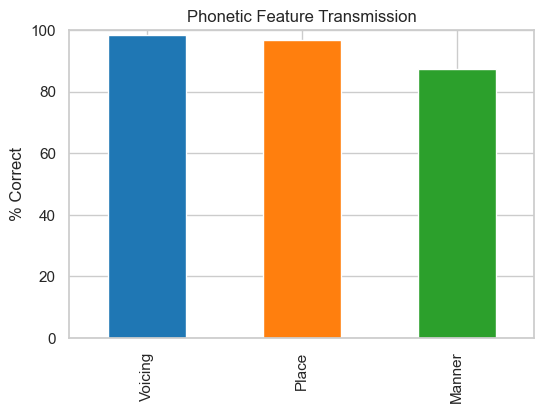

In [4]:
print("--- 1.1 Phonetic Feature Analysis ---")

# Feature Map: Maps consonant characters to (Voicing, Place, Manner)
# 1 = Feature Present/High, 0 = Feature Absent/Low
feature_map = {
    'b': (1, 1, 0), 'd': (1, 0, 0), 'g': (1, 0, 0),
    'p': (0, 1, 0), 't': (0, 0, 0), 'k': (0, 0, 0),
    'm': (1, 1, 1), 'n': (1, 0, 1),
    'f': (0, 1, 2), 'v': (1, 1, 2), 's': (0, 0, 2), 'z': (1, 0, 2),
    '#': (0, 0, 2), '_': (1, 0, 2), # Sh, Zh
    '%': (0, 0, 3), '$': (1, 0, 3)  # Ch, J
}

def calculate_information_transfer(df, label_col, resp_col, feat_map):
    # Filter for valid keys
    valid = df[df[label_col].isin(feat_map.keys()) & df[resp_col].isin(feat_map.keys())]
    if len(valid) == 0: return None
    
    features = ['Voicing', 'Place', 'Manner']
    results = {}
    
    for i, feat_name in enumerate(features):
        t_feat = valid[label_col].apply(lambda x: feat_map[x][i])
        r_feat = valid[resp_col].apply(lambda x: feat_map[x][i])
        # Calculate simple percent correct for that feature
        acc = (t_feat == r_feat).mean() * 100
        results[feat_name] = acc
        
    return pd.Series(results)

if 'df_consonant' in locals():
    feat_res = calculate_information_transfer(df_consonant, 'consonant_label', 'response_label', feature_map)
    if feat_res is not None:
        print("Feature Transmission Rates (% Correct):")
        print(feat_res.round(2))
        
        # Plot
        plt.figure(figsize=(6, 4))
        feat_res.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.title('Phonetic Feature Transmission')
        plt.ylabel('% Correct')
        plt.ylim(0, 100)
        plt.show()

--- 1.2 Advanced Heatmaps (Cluster Organized) ---


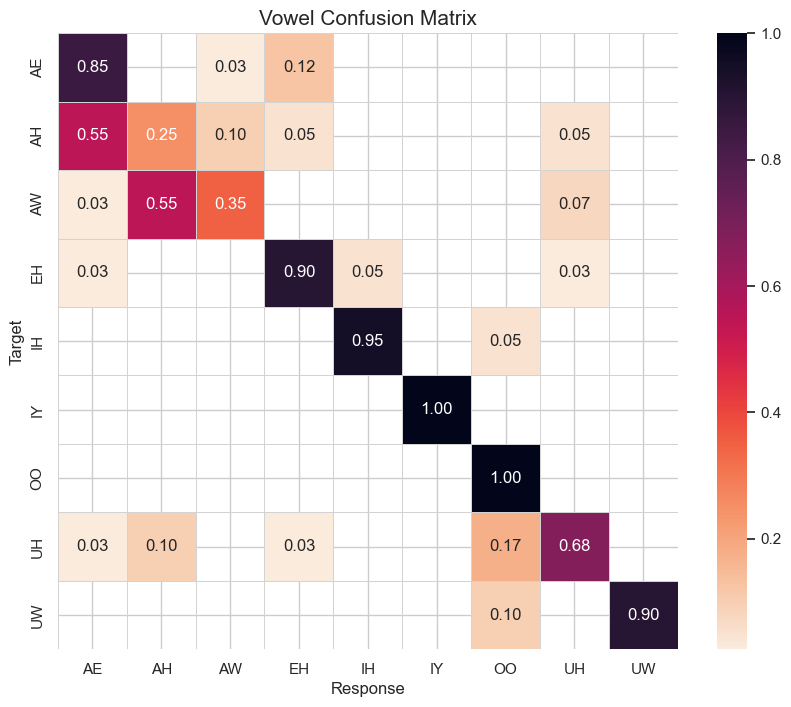

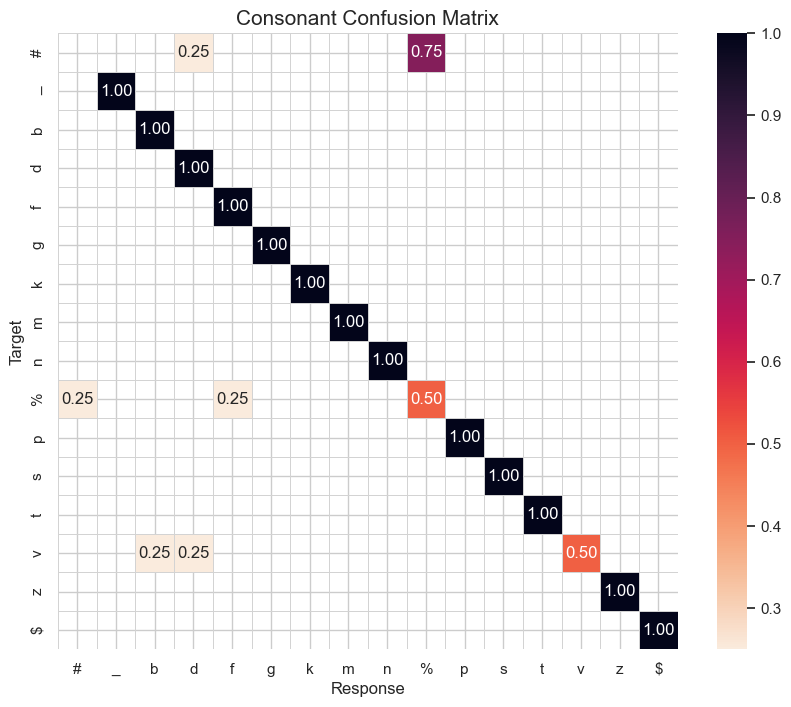

In [5]:
print("--- 1.2 Advanced Heatmaps (Cluster Organized) ---")

def plot_clustered_matrix(df, target_col, resp_col, map_dict, title):
    labels = [v for k, v in sorted(map_dict.items())]
    
    # Generate Counts
    cm = pd.crosstab(df[target_col], df[resp_col])
    # Reindex to ensure all labels exist
    cm = cm.reindex(index=labels, columns=labels, fill_value=0)
    # Normalize row-wise (Probability)
    cm_prob = cm.div(cm.sum(axis=1), axis=0).fillna(0)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_prob, annot=True, fmt='.2f', cmap='rocket_r', 
                mask=(cm_prob==0), linewidths=0.5, linecolor='lightgray')
    plt.title(title, fontsize=15)
    plt.ylabel('Target')
    plt.xlabel('Response')
    plt.show()

if 'df_vowel' in locals():
    plot_clustered_matrix(df_vowel, 'vowel_label', 'response_label', vowel_map, "Vowel Confusion Matrix")

if 'df_consonant' in locals():
    plot_clustered_matrix(df_consonant, 'consonant_label', 'response_label', cons_map, "Consonant Confusion Matrix")

--- 1.3 CRM Distributional Analysis (Violin Plot) ---


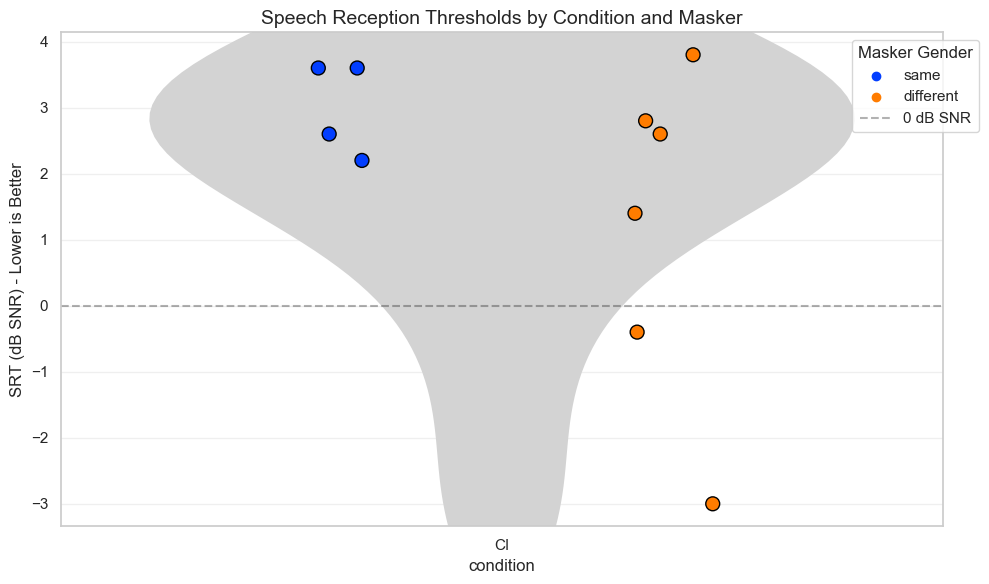

In [6]:
print("--- 1.3 CRM Distributional Analysis (Violin Plot) ---")

if 'df_crm_summary' in locals() and not df_crm_summary.empty:
    plt.figure(figsize=(10, 6))
    
    # Violin plot shows density, Strip plot shows individual run data points
    sns.violinplot(x='condition', y='srt', data=df_crm_summary, inner=None, color='lightgray', linewidth=0)
    sns.stripplot(x='condition', y='srt', data=df_crm_summary, hue='masker_type', 
                  size=10, jitter=True, palette='bright', dodge=True, edgecolor='black', linewidth=1)
    
    plt.axhline(0, color='black', linestyle='--', alpha=0.3, label='0 dB SNR')
    plt.title('Speech Reception Thresholds by Condition and Masker', fontsize=14)
    plt.ylabel('SRT (dB SNR) - Lower is Better')
    plt.legend(title='Masker Gender', bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("CRM Summary data not available for plotting.")

# Version 2: Exploratory & Statistical Analysis
This section looks for temporal trends (fatigue/learning), performs statistical significance testing, and provides interactive exploration tools.

--- 2.1 Temporal Analysis (Fatigue / Learning Effects) ---


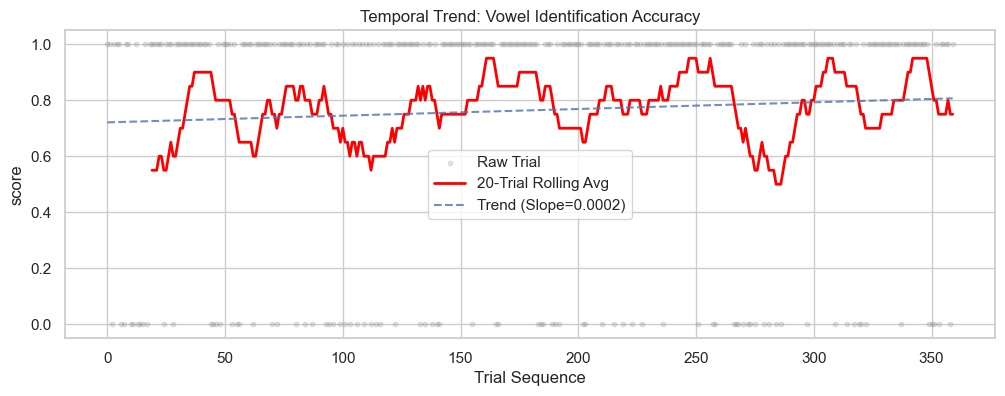

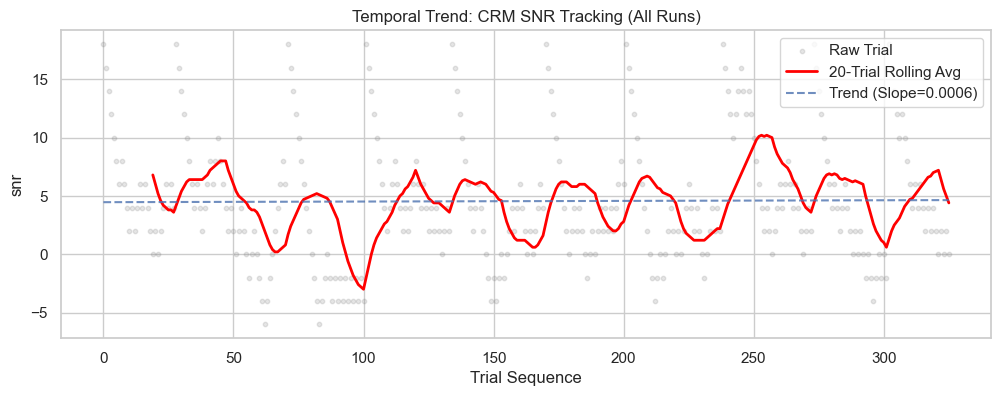

In [7]:
print("--- 2.1 Temporal Analysis (Fatigue / Learning Effects) ---")

def plot_temporal_trend(df, metric_col, title):
    # Reset index to get global trial count
    df_seq = df.reset_index(drop=True).reset_index().rename(columns={'index': 'trial'})
    
    # Calculate rolling average
    df_seq['rolling'] = df_seq[metric_col].rolling(window=20).mean()
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_seq['trial'], df_seq[metric_col], alpha=0.2, color='gray', s=10, label='Raw Trial')
    plt.plot(df_seq['trial'], df_seq['rolling'], color='red', linewidth=2, label='20-Trial Rolling Avg')
    
    # Simple Linear Regression for Trend
    z = np.polyfit(df_seq['trial'], df_seq[metric_col].fillna(0), 1)
    p = np.poly1d(z)
    plt.plot(df_seq['trial'], p(df_seq['trial']), "b--", alpha=0.8, label=f'Trend (Slope={z[0]:.4f})')
    
    plt.title(f'Temporal Trend: {title}')
    plt.xlabel('Trial Sequence')
    plt.ylabel(metric_col)
    plt.legend()
    plt.show()
    
    if z[0] < -0.001: print("-> Potential Fatigue/Decline detected (Negative Slope)")
    if z[0] > 0.001: print("-> Potential Learning/Improvement detected (Positive Slope)")

if 'df_vowel' in locals():
    plot_temporal_trend(df_vowel, 'score', "Vowel Identification Accuracy")

if 'df_crm' in locals():
    # Filter out ridiculously high SNRs (initial trials)
    crm_clean = df_crm[df_crm['snr'] < 20]
    plot_temporal_trend(crm_clean, 'snr', "CRM SNR Tracking (All Runs)")

--- 2.2 Statistical Testing (ANOVA) ---
Not enough conditions for ANOVA.

--- 2.3 Advanced CRM Error Analysis ---


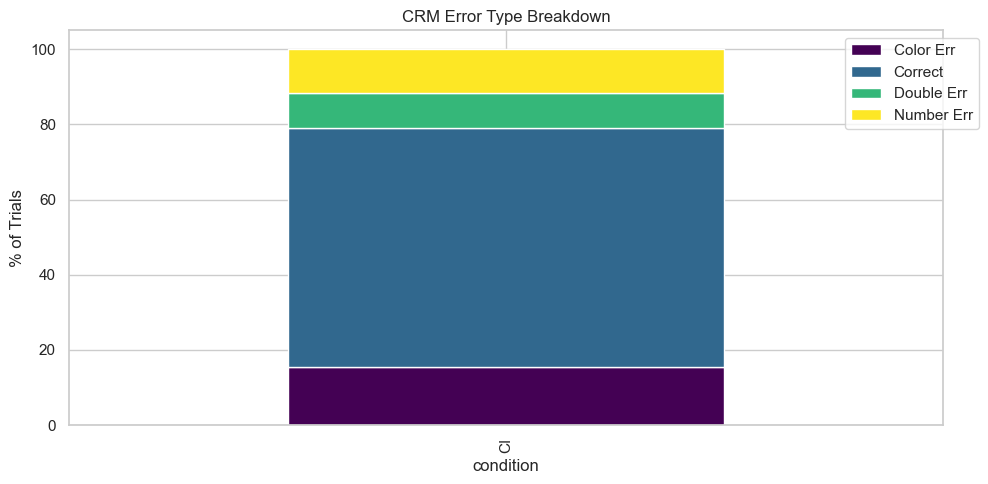

In [8]:
print("--- 2.2 Statistical Testing (ANOVA) ---")

if 'df_crm_summary' in locals():
    # Filter valid data
    stat_df = df_crm_summary[df_crm_summary['condition'] != 'Unknown'].dropna()
    
    if len(stat_df['condition'].unique()) > 1:
        print("\nRunning ANOVA on CRM SRTs (Condition + MaskerType)...")
        try:
            model = ols('srt ~ C(condition) + C(masker_type)', data=stat_df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            print(anova_table)
            
            if anova_table['PR(>F)'][0] < 0.05:
                print("\n-> Significant Condition Effect detected. Suggest Post-hoc t-tests.")
            else:
                print("\n-> No significant differences detected between conditions (p > 0.05).")
        except Exception as e:
            print(f"Stats error: {e} (Likely insufficient data points)")
    else:
        print("Not enough conditions for ANOVA.")
        
print("\n--- 2.3 Advanced CRM Error Analysis ---")
# Breakdown errors by type: Color wrong? Number wrong? Both?

if 'df_crm' in locals():
    def classify_error(row):
        c_ok = row['target_color'] == row['response_color']
        n_ok = row['target_number'] == row['response_number']
        if c_ok and n_ok: return 'Correct'
        if c_ok and not n_ok: return 'Number Err'
        if not c_ok and n_ok: return 'Color Err'
        return 'Double Err'

    df_crm['err_type'] = df_crm.apply(classify_error, axis=1)
    
    err_counts = df_crm.groupby(['condition', 'err_type']).size().unstack(fill_value=0)
    # Normalize to percentage
    err_pct = err_counts.div(err_counts.sum(axis=1), axis=0) * 100
    
    err_pct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 5))
    plt.title('CRM Error Type Breakdown')
    plt.ylabel('% of Trials')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

In [9]:
from ipywidgets import interact, fixed

print("--- 2.4 Interactive Data Explorer ---")
print("(If visualizations do not appear, ensure all previous cells ran successfully)")

# -------------------------------------------------------
# 1. VOWEL EXPLORER
# -------------------------------------------------------
def plot_vowel_metrics(talker_id, condition):
    # scope check
    if 'df_vowel' not in globals():
        print("Error: df_vowel not loaded. Run Section 2 first.")
        return

    data = df_vowel.copy()
    
    # Filter
    if talker_id != 'All':
        data = data[data['talker_id'] == talker_id]
    if condition != 'All':
        data = data[data['condition'] == condition]
        
    if len(data) == 0:
        print("No data for this selection.")
        return

    # Calculate Metrics
    acc = data['score'].mean() * 100
    mean_rt = data['rt'].mean()
    
    print(f"--- Vowel Statistics (n={len(data)}) ---")
    print(f"Accuracy:      {acc:.2f}%")
    print(f"Mean Reaction: {mean_rt:.2f}s")
    
    # Simple Bar Plot for Accuracy per Vowel
    plt.figure(figsize=(10, 4))
    vowel_acc = data.groupby('vowel_label')['score'].mean() * 100
    sns.barplot(x=vowel_acc.index, y=vowel_acc.values, palette='viridis')
    plt.title('Accuracy by Phoneme')
    plt.ylim(0, 100)
    plt.ylabel('% Correct')
    plt.show()

if 'df_vowel' in locals():
    print("\n>> VOWEL EXPLORER")
    talkers = ['All'] + sorted(list(df_vowel['talker_id'].unique()))
    conds = ['All'] + sorted(list(df_vowel['condition'].unique()))
    
    interact(plot_vowel_metrics, talker_id=talkers, condition=conds)
else:
    print("Skipping Vowel Explorer (Data not loaded)")

# -------------------------------------------------------
# 2. CRM EXPLORER
# -------------------------------------------------------
def plot_crm_track(filename):
    # scope check
    if 'df_crm' not in globals():
        print("Error: df_crm not loaded.")
        return
        
    data = df_crm[df_crm['filename'] == filename].copy()
    if len(data) == 0: return
    
    # Calculate Correctness for color coding
    data['correct'] = (data['target_color'] == data['response_color']) & \
                      (data['target_number'] == data['response_number'])
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(data)), data['snr'], 'b-', alpha=0.5)
    
    # Plot Correct as Green, Incorrect as Red
    correct_trials = data[data['correct']]
    incorrect_trials = data[~data['correct']]
    
    plt.scatter(correct_trials.index - data.index[0], correct_trials['snr'], c='green', label='Correct')
    plt.scatter(incorrect_trials.index - data.index[0], incorrect_trials['snr'], c='red', label='Incorrect')
    
    plt.title(f"Adaptive Track: {filename}")
    plt.xlabel("Trial")
    plt.ylabel("SNR (dB)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if 'df_crm' in locals():
    print("\n>> CRM TRACK EXPLORER")
    files = sorted(list(df_crm['filename'].unique()))
    interact(plot_crm_track, filename=files)
else:
    print("Skipping CRM Explorer (Data not loaded)")

--- 2.4 Interactive Data Explorer ---
(If visualizations do not appear, ensure all previous cells ran successfully)

>> VOWEL EXPLORER


interactive(children=(Dropdown(description='talker_id', options=('All', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…


>> CRM TRACK EXPLORER


interactive(children=(Dropdown(description='filename', options=('CI148_crm_0.txt', 'CI148_crm_1.txt', 'CI148_c…